![](https://i.imgur.com/lWYHy5f.jpg)

<h1><center><font color='#922B21'>EYE FOR BLIND - Capstone Project</h1></center></font> 
<center><font color='#808080';size = '3'>By: Simran Kaur Badan</center></font>


<b><u><font color = '#F05131'>Problem Statement:</b></u></font>

In this capstone project, you need to create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library. 

This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by a CNN-based encoder and this will be decoded by an RNN model.



The major steps that you have to perform can be briefly summarised in the following four steps:

* Data Understanding: Here, you need to load the data and understand the representation.
* Data Preprocessing: In this step, you will process both images and captions to the desired format.
* Train-Test Split: Combine both images and captions to create the train and test dataset.
* Model Building: This is the stage where you will create your image captioning model by building Encoder, Attention and Decoder model.
* Model Evaluation: Evaluate the models using greedy search and BLEU score.

In [1]:
#Import all the required libraries
import warnings
warnings.filterwarnings("ignore")
import os, glob
from heapq import nlargest
import operator

#Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Conv2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model

# Plotting libraries
from skimage import io
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


#Other required libraries

import numpy as np
import pandas as pd
import collections, random, re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import nltk

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [2]:
#Import the dataset and read the image into a seperate variable

images='Images/'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


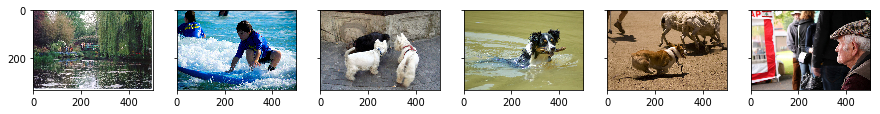

In [3]:
#Visualise both the images & text present in the dataset

def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
   
    for ax,image in zip(axes, images):
        ax.imshow(io.imread(image), cmap)
        
plot_image(all_imgs[8085:])

In [4]:
#Import the dataset and read the text file into a seperate variable
text_file = 'captions.txt'
def load_doc(filename):
    
    #your code here
    file1 = open(filename,'r')
    text = file1.readlines()
    return text

doc = load_doc(text_file)
# print(doc[:300])

#visualize few captions
for i in range(1, 15):
    print(doc[i])


1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .

1000268201_693b08cb0e.jpg,A girl going into a wooden building .

1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .

1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .

1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .

1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting

1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .

1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .

1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .

1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .

1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .

1002674143_1b742ab4b8.jp

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [5]:
anno = []
ID = []
path = []
ID_final = []
for i in range(1, len(doc)):
    anno.append(doc[i].split(',')[1])
    path.append(str('Images/' + str(doc[i].split(',')[0])))
    ID = str(doc[i].split(',')[0])
    ID_final.append(ID.split('.')[0])

In [6]:
all_img_id= ID_final #store all the image id here
all_img_vector = path    #store all the image path here
annotations= anno        #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
df.reset_index(drop=True, inplace=True)
df

,ID,Path,Captions
0,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n
2,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse...
3,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70,Images/1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n
6,1001773457_577c3a7d70,Images/1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70,Images/1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70,Images/1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70,Images/1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n


In [7]:
images = np.unique(df.ID.values)
print("The number of unique images in the dataset : " + str(format(len(images))))

The number of unique images in the dataset : 8091


In [8]:
def sentence_split(sen):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sen.lower())))

def vocabulary(captions):
    words = []
    for sentence in captions:
        sent_words = sentence_split(sentence)
        for word in sent_words: 
            words.append(word)
    return words
    
vocab = vocabulary(df['Captions'])
len(vocab)

419977

In [9]:
#Create the vocabulary & the counter for the captions

vocabulary= Counter(vocab)  #write your code here

val_count=Counter(vocabulary)

<BarContainer object of 30 artists>

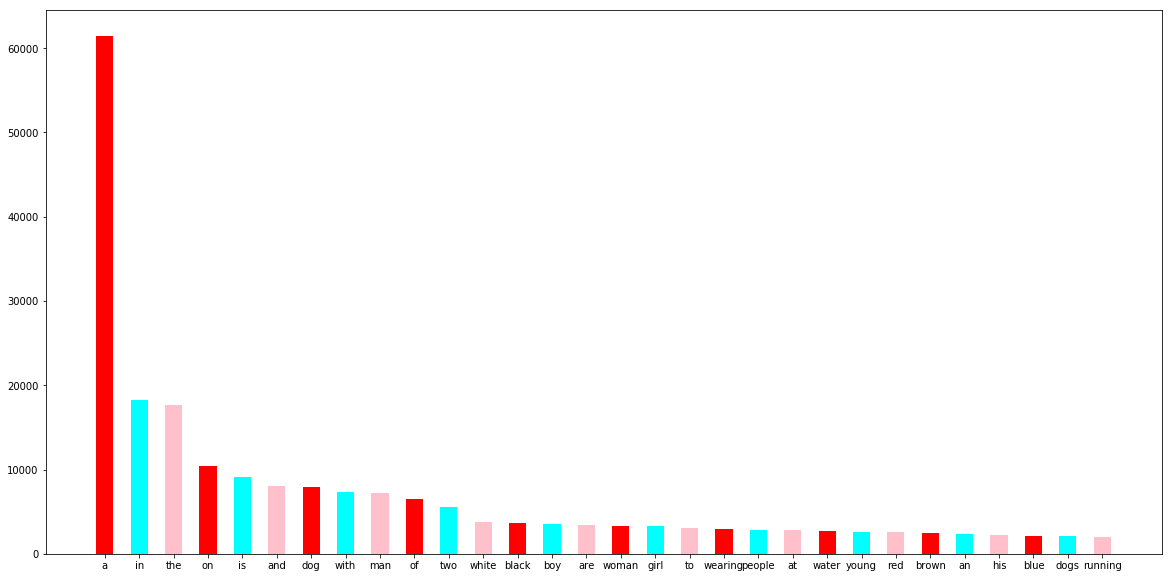

In [10]:
#Visualise the top 30 occuring words in the captions

top_30 = dict(val_count.most_common(30))
top_30_words = top_30.keys()
top_30_counts = top_30.values()

plt.figure(figsize=(20,10))
plt.bar(top_30_words, top_30_counts, color=['red', 'aqua', 'pink'],width = 0.5)

In [11]:
#Create a list which contains all the captions
annotations = df['Captions']  #write your code here

#add the <start> & <end> token to all those captions as well
df['Captions']=df.Captions.apply(lambda x : f"<start> {x} <end>")

#Create a list which contains all the path to the images
all_img_path = all_img_vector  #write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total unique images present in the dataset: " + str(len(images)))

Total captions present in the dataset: 40455
Total unique images present in the dataset: 8091


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [12]:
# create the tokenizer
special_char = '/:;=?@[\]^_`{|}~ !"#$%&()*+.,-'

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 5000, oov_token="UNK", filters=special_char)
tokenizer.fit_on_texts(annotations)

t = tokenizer.texts_to_sequences(annotations)

# padding each vector
t_pad = tf.keras.preprocessing.sequence.pad_sequences(t, padding='post')
t_pad

array([[ 3,  2, 44, ...,  0,  0,  0],
       [ 3,  2, 21, ...,  0,  0,  0],
       [ 3,  2, 40, ...,  0,  0,  0],
       ...,
       [ 3,  2, 43, ...,  0,  0,  0],
       [ 3,  2, 85, ...,  0,  0,  0],
       [ 3,  2, 85, ...,  0,  0,  0]], dtype=int32)

In [13]:
# create word-to-index and index-to-word mappings

def word_to_index(word):
    print("Word = {}, index = {}".format(word, tokenizer.word_index[word]))

def index_to_word(index):
    print("Index = {}, Word = {}".format(index, tokenizer.index_word[index]))
    

          
print( "Word to index mapping")
word_to_index("image")
print("---------------------------------------------------------------------------------------------------\n")
print("Index to Word Mapping")
index_to_word(30)

Word to index mapping
Word = image, index = 1260
---------------------------------------------------------------------------------------------------

Index to Word Mapping
Index = 30, Word = an


In [14]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

token_count = dict(tokenizer.word_counts)
top_30 = sorted(token_count.items(), key=operator.itemgetter(1),reverse=True)
top_30[:30]

[('a', 61431),
 ('<start>', 40455),
 ('<end>', 40455),
 ('\n', 34295),
 ('in', 18191),
 ('the', 17676),
 ('on', 10350),
 ('is', 9069),
 ('and', 8066),
 ('dog', 7923),
 ('with', 7308),
 ('man', 7164),
 ('of', 6503),
 ('two', 5550),
 ('white', 3727),
 ('black', 3638),
 ('boy', 3532),
 ('are', 3365),
 ('woman', 3316),
 ('girl', 3279),
 ('to', 3007),
 ('wearing', 2917),
 ('people', 2832),
 ('at', 2820),
 ('young', 2610),
 ('red', 2571),
 ('water', 2555),
 ('brown', 2484),
 ('an', 2358),
 ('his', 2255)]

In [15]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

print("The shape of Caption vector is :" + str(t_pad.shape))

The shape of Caption vector is :(40455, 36)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [16]:
#write your code here

def preprocess(image_path):
    shape = (299, 299)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,shape)
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, image_path

feature_dict = {}

image_dataset = tf.data.Dataset.from_tensor_slices(all_imgs)
image_dataset = image_dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

# Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [17]:
#write your code here
image_train, image_test, captions_train, captions_test = train_test_split(all_img_vector,t_pad, test_size=0.2, random_state=42)

In [18]:
print("Image_train = {}, Captions_train = {}".format(len(image_train), len(captions_train)))
print("Image_test = {}, Captions_test = {}".format(len(image_test), len(captions_test)))

Image_train = 32364, Captions_train = 32364
Image_test = 8091, Captions_test = 8091


In [19]:
sample_img_batch, sample_cap_batch = next(iter(image_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(32, 299, 299, 3)
(32,)


In [20]:
def map_function(image_name,capt):
    image_tensor = feature_dict[image_name.decode('utf-8')]
    return image_tensor,capt

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [21]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input                                            #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output                             #write code here to get the output of the image_model

image_features_extract_model = keras.Model(new_input, hidden_layer)      #build the final model using both input & output layer

87916544/87910968 [==============================] - 1s 0us/step


In [22]:
# write your code to extract features from each image in the dataset

image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [23]:
# extracting features of each image
from tqdm import tqdm
for image,path in tqdm(image_dataset):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

253it [16:31,  3.69s/it]


In [24]:
batch_f.shape

TensorShape([64, 2048])

In [25]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000


def generate_dataset(images_data, captions_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [26]:
train_dataset=generate_dataset(image_train,captions_train)
test_dataset=generate_dataset(image_test,captions_test)

In [27]:
train_dataset

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

In [28]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(32, 64, 2048)
(32, 36)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [29]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(image_train) // BATCH_SIZE
test_num_steps = len(image_test) // BATCH_SIZE

### Encoder

In [30]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.fc = layers.Dense(embed_dim)
        self.dropout = layers.Dropout(0.5)
        
    def call(self, features):
        features = self.fc(features)
        features = tf.nn.relu(features)
        return features

In [31]:
encoder=Encoder(embedding_dim)

### Attention model

In [32]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights =  keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        

        return context_vector, attention_weights

In [33]:
class RNN_Decoder(Model):
    def __init__(self, embedding_dim, units, vocab_size):

        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.gru = layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.fc1 = layers.Dense(self.units)
        self.fc2 = layers.Dense(vocab_size)

        self.attention = Attention_model(self.units)

    def call(self, x, features, hidden):
    # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
        output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

### Decoder

In [34]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = layers.Embedding(vocab_size, embed_dim,mask_zero=False)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)
        self.d2 = layers.Dense(vocab_size)   
        self.dropout = Dropout(0.5)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed = self.dropout(self.embed(x)) 
        mask = self.embed.compute_mask(x)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output,state = self.gru(embed,mask=mask)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) 
        output = self.d2(output) 

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [35]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [36]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) 
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) 
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape))

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [37]:
optimizer = keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [38]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [39]:
checkpoint_path = "Check"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,
                                          checkpoint_path,
                                          max_to_keep=5)

In [40]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [41]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss, avg_loss

In [42]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, avg_loss

In [43]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    return avg_test_loss

In [45]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

import time

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.241, & test loss is 1.053
Time taken for 1 epoch 1908.412936925888 sec

Test loss has been reduced from 100.000 to 1.053


 13%|█▎        | 2/15 [1:01:31<6:45:20, 1870.84s/it]

For epoch: 2, the train loss is 0.979, & test loss is 0.936
Time taken for 1 epoch 1782.480706691742 sec

Test loss has been reduced from 1.053 to 0.936


 20%|██        | 3/15 [1:32:16<6:12:37, 1863.13s/it]

For epoch: 3, the train loss is 0.895, & test loss is 0.869
Time taken for 1 epoch 1845.0482051372528 sec

Test loss has been reduced from 0.936 to 0.869


 27%|██▋       | 4/15 [2:03:49<5:43:11, 1872.00s/it]

For epoch: 4, the train loss is 0.836, & test loss is 0.813
Time taken for 1 epoch 1892.5642020702362 sec

Test loss has been reduced from 0.869 to 0.813


 33%|███▎      | 5/15 [2:34:17<5:09:48, 1858.85s/it]

For epoch: 5, the train loss is 0.786, & test loss is 0.766
Time taken for 1 epoch 1828.052090883255 sec

Test loss has been reduced from 0.813 to 0.766


 40%|████      | 6/15 [3:04:45<4:37:26, 1849.61s/it]

For epoch: 6, the train loss is 0.742, & test loss is 0.724
Time taken for 1 epoch 1827.9552960395813 sec

Test loss has been reduced from 0.766 to 0.724


 47%|████▋     | 7/15 [3:35:03<4:05:20, 1840.09s/it]

For epoch: 7, the train loss is 0.702, & test loss is 0.686
Time taken for 1 epoch 1817.7465376853943 sec

Test loss has been reduced from 0.724 to 0.686


 53%|█████▎    | 8/15 [4:04:14<3:31:33, 1813.41s/it]

For epoch: 8, the train loss is 0.665, & test loss is 0.649
Time taken for 1 epoch 1751.0625693798065 sec

Test loss has been reduced from 0.686 to 0.649


 60%|██████    | 9/15 [4:33:37<2:59:49, 1798.25s/it]

For epoch: 9, the train loss is 0.631, & test loss is 0.618
Time taken for 1 epoch 1762.7480902671814 sec

Test loss has been reduced from 0.649 to 0.618


 67%|██████▋   | 10/15 [5:03:21<2:29:30, 1794.01s/it]

For epoch: 10, the train loss is 0.599, & test loss is 0.586
Time taken for 1 epoch 1784.012357711792 sec

Test loss has been reduced from 0.618 to 0.586


 73%|███████▎  | 11/15 [5:32:37<1:58:50, 1782.72s/it]

For epoch: 11, the train loss is 0.570, & test loss is 0.559
Time taken for 1 epoch 1756.2607424259186 sec

Test loss has been reduced from 0.586 to 0.559


 80%|████████  | 12/15 [6:02:53<1:29:38, 1792.73s/it]

For epoch: 12, the train loss is 0.545, & test loss is 0.535
Time taken for 1 epoch 1815.9880537986755 sec

Test loss has been reduced from 0.559 to 0.535


 87%|████████▋ | 13/15 [6:32:36<59:39, 1789.61s/it]  

For epoch: 13, the train loss is 0.520, & test loss is 0.510
Time taken for 1 epoch 1782.2128493785858 sec

Test loss has been reduced from 0.535 to 0.510


 93%|█████████▎| 14/15 [7:01:25<29:31, 1771.62s/it]

For epoch: 14, the train loss is 0.496, & test loss is 0.488
Time taken for 1 epoch 1729.5357801914215 sec

Test loss has been reduced from 0.510 to 0.488


100%|██████████| 15/15 [7:29:58<00:00, 1753.90s/it]

For epoch: 15, the train loss is 0.479, & test loss is 0.469
Time taken for 1 epoch 1712.4200448989868 sec

Test loss has been reduced from 0.488 to 0.469


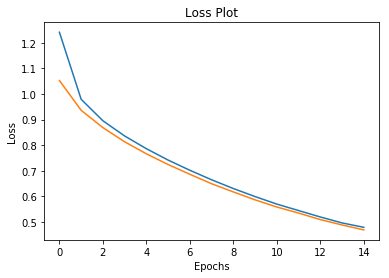

In [46]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [63]:
def evaluate(image):
    max_length=max_l
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

### Beam Search(optional)

In [61]:
def beam_evaluate(image, beam_index = 3):
    max_length=max_l
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [49]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [50]:
from nltk.translate.bleu_score import sentence_bleu

In [51]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [52]:
import numpy as np

In [53]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

7127
BELU score: 80.91067115702212
Real Caption: the young girl is cross country skiing
Prediction Caption: a young girl is cross country skiing 



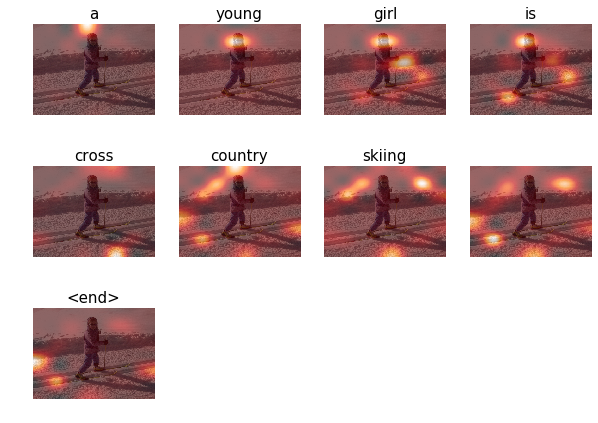

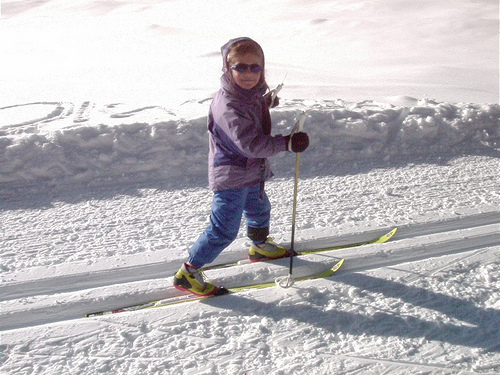

In [64]:
def min_max_for_nested_array(nested_array):
    array=[len(e) for e in nested_array]
    return min(array),max(array)
min_l,max_l=min_max_for_nested_array(t)



rid = np.random.randint(0, len(image_test))
print(rid)
test_image = image_test[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in captions_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [65]:
captions=beam_evaluate(test_image)
print(pred_caption)

a young girl is cross country skiing 



In [ ]:
import pyttsx3 
engine = pyttsx3.init()
engine.say(pred_caption)
engine.runAndWait()

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*- END *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-